# 长期价值投资数据监测

In [1]:
#imports

import yfinance as yf
import pandas as pd
import datetime as dt
import seaborn as sns
import getdata as gd
from  matplotlib import pyplot as plt

#init
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, 
            rc={'figure.figsize':(15,10)})
#pd.options.display.float_format = '{:,.2f}'.format

#parameters
ticker_list=['FB','MSFT','AAPL','GOOG','AMZN','PFE','MCD',
'NVDA','0700.HK','ADBE','MO','ADSK','ASML','BRK-B',
'GS','ISRG','KO','LVMUY','2318.HK','TSM','ADBE','MCO'

]



In [2]:
print('This notebook was refreshed at %s'%(dt.datetime.now()))

This notebook was refreshed at 2022-03-13 18:44:31.589094


## 美国国债收益率监测

In [3]:
df_rate_10y=pd.DataFrame()
data=yf.download(['^IRX','^FVX','^TNX','^TYX'],progress=False)

df_rate_10y=data.loc[dt.date.today()-dt.timedelta(days=365*10):]['Close']
df_rate_10y.columns=['5 Years','13 Weeks','10 Years','30 Years']

In [4]:
s=df_rate_10y.tail(1).style.format('{:.3f}%')
s

,5 Years,13 Weeks,10 Years,30 Years
Date,,,,
2022-03-11 00:00:00,1.960%,0.365%,2.004%,2.364%


Text(0.5, 1.0, '10 years trend of treasury yield')

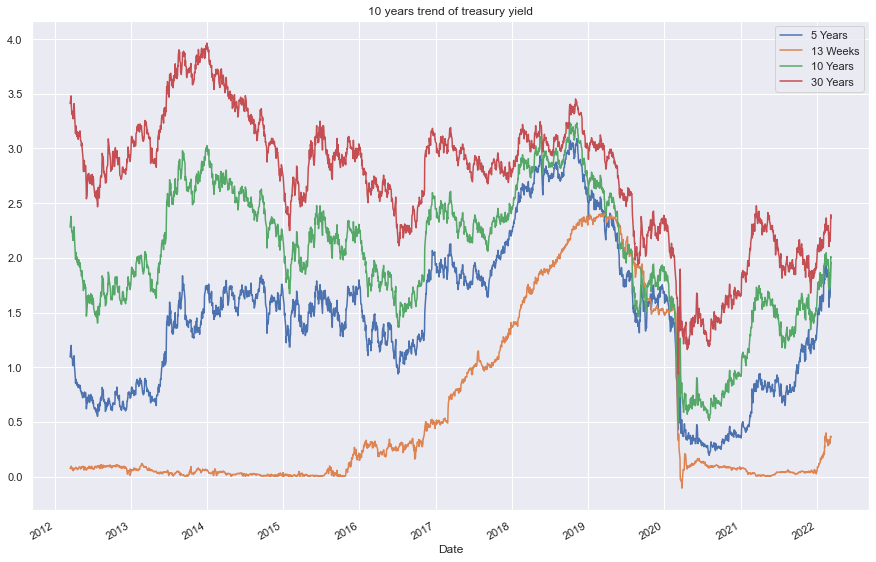

In [5]:
df_rate_10y.plot()
plt.title("10 years trend of treasury yield")

Text(0.5, 1.0, '1 year trend of treasury yield')

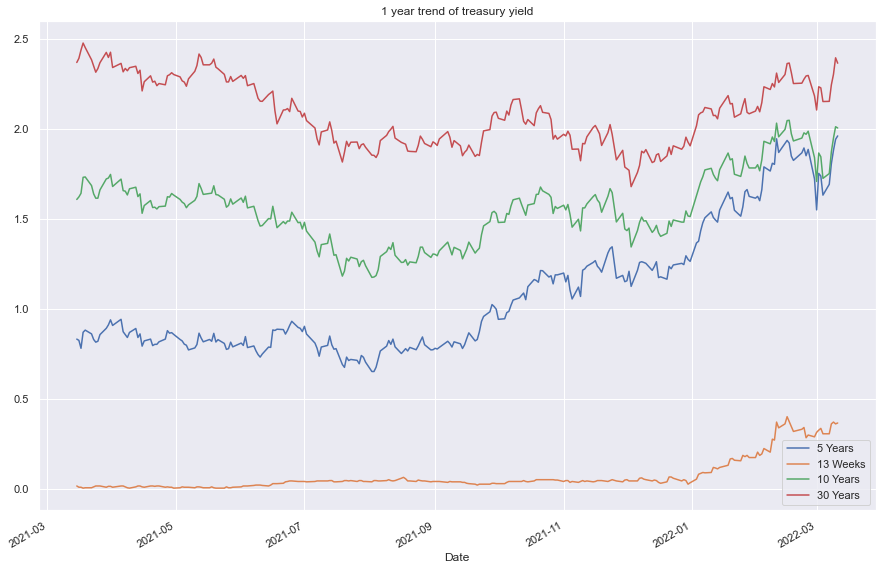

In [6]:
df_rate_1y=pd.DataFrame()
data=yf.download(['^IRX','^FVX','^TNX','^TYX'],progress=False)

df_rate_1y=data.loc[dt.date.today()-dt.timedelta(days=365):]['Close']
df_rate_1y.columns=['5 Years','13 Weeks','10 Years','30 Years']
df_rate_1y.plot()
plt.title("1 year trend of treasury yield")

## 股市和国债利率的相关度

## 跟踪公司数据监控

In [7]:

ticker_list=list(dict.fromkeys(ticker_list))
df_port=pd.DataFrame()
df_port['ticker']=ticker_list
df_port['weight']=0

In [8]:
df_stock=gd.get_port_holding_info(df_port)
df_stock.to_csv('../data/share/value_port_info.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

/Users/weiqinchen/Documents/Python/skydog/notebooks/getdata.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stock['weight']=df_port['weight']/100
/Users/weiqinchen/Documents/Python/skydog/notebooks/getdata.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stock['ratecode']=df_stock['financialCurrency']+'-USD'
/Users/weiqinchen/Documents/Python/skydog/notebooks/getdata.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

In [9]:
df_stock=pd.read_csv('../data/share/value_port_info.csv')
df_metric=gd.get_port_holding_metric(df_stock)

In [12]:
df_metric.reindex(columns=['ticker','eps_ttm','price','1w_chg_pct','drawdown','target_price','roe','cf_margin','net_margin']
).sort_values(by='1w_chg_pct').style.format(precision=2,
        formatter={'drawdown':'{:.2f}%',
                    '1w_chg_pct':'{:.2f}%',
                    'revenue_growth':'{:.2f}%',
                    'cash_return_rate':'{:.2f}%',
                    'roe':'{:.2f}%',
                    'gross_margin':'{:.2f}%',
                    'net_margin':'{:.2f}%',
                    'cf_margin':'{:.2f}%',
        
         })

,ticker,eps_ttm,price,1w_chg_pct,drawdown,target_price,roe,cf_margin,net_margin
15,ISRG,4.66,273.69,-9.46%,-25.10%,334.00,15.92%,36.59%,29.85%
8,0700.HK,11.01,367.80,-8.78%,-45.80%,589.88,24.27%,31.44%,34.42%
9,ADBE,10.02,416.38,-7.91%,-39.51%,660.00,34.37%,45.80%,30.55%
16,KO,2.25,57.92,-7.43%,-7.84%,67.50,42.49%,32.66%,25.28%
11,ADSK,2.24,192.31,-7.39%,-43.81%,285.00,54.78%,34.91%,11.33%
20,MCO,11.78,304.47,-6.56%,-24.85%,401.00,94.64%,32.25%,35.61%
0,FB,13.77,187.61,-6.22%,-50.91%,340.00,31.10%,48.91%,33.38%
10,MO,1.34,50.48,-5.63%,-5.63%,53.00,364.24%,39.81%,11.72%
18,2318.HK,9.40,54.85,-5.51%,-42.48%,84.98,15.52%,15.41%,10.16%
2,AAPL,6.01,154.73,-5.17%,-14.88%,199.50,145.57%,29.67%,26.58%
